# Bicycle Demand Prediction

AIM: To predict the demand of bicycles every hour to make sure adequate amount of bicycles are available for travel.

In [161]:
#Imports
import pandas as pd
pd.pandas.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import scipy
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

## Data Analysis
This notebook consists of analyzing the dataset to understand the trends and patterns in the dataset to create accurate models for demand prediction.


### Load the Dataset

In [162]:
# Import Data
path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/raw_data/SeoulBikeData.csv'
raw_df = pd.read_csv(path, encoding='unicode_escape')

print("Total Rows and features are: , ", raw_df.shape)
raw_df.head()

Total Rows and features are: ,  (8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [163]:
# Columns
print(f"Different features are {raw_df.columns}")

Different features are Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


1. Date : year-month-day
2. Rented Bike count - Count of bikes rented at each hour
3. Hour - Hour of he day
4. Temperature-Temperature in Celsius
5. Humidity - %
6. Windspeed - m/s
7. Visibility - 10m
8. Dew point temperature - Celsius 
9. Solar radiation - MJ/m2
10. Rainfall - mm
11. Snowfall - cm
12. Seasons - Winter, Spring, Summer, Autumn
13. Holiday - Holiday/No holiday
14. Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

Here, our target feature is the Rented Bike Count. All other features are the independent features.


#### 1. Clean Column names

In [164]:
#name mapper
column_name_mapper = {'Temperature(°C)': 'Temperature', 'Humidity(%)': 'Humidity', 
                      'Wind speed (m/s)': 'Wind speed', 'Visibility (10m)': 'Visibility', 
                      'Dew point temperature(°C)': 'Dew point temperature', 'Solar Radiation (MJ/m2)': 'Solar Radiation', 
                      'Rainfall(mm)': 'Rainfall', 'Snowfall (cm)': 'Snowfall'
                      }

def clean_col_names(df: pd.DataFrame, column_name_mapper: dict) -> pd.DataFrame:
    df = df.rename(columns=column_name_mapper)  # rename
    df.columns = df.columns.str.lower() # lower case
    df.columns = df.columns.str.replace('\s+', '_', regex=True) # replace space with '_'

    return df

# apply function
raw_df = clean_col_names(raw_df, column_name_mapper=column_name_mapper)
raw_df.columns, len(raw_df.columns)

(Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
        'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation',
        'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day'],
       dtype='object'),
 14)

### Descriptive Stats

Checking the basic statistics of the data.

In [165]:
# Dataframe Info
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   8760 non-null   object 
 1   rented_bike_count      8760 non-null   int64  
 2   hour                   8760 non-null   int64  
 3   temperature            8760 non-null   float64
 4   humidity               8760 non-null   int64  
 5   wind_speed             8760 non-null   float64
 6   visibility             8760 non-null   int64  
 7   dew_point_temperature  8760 non-null   float64
 8   solar_radiation        8760 non-null   float64
 9   rainfall               8760 non-null   float64
 10  snowfall               8760 non-null   float64
 11  seasons                8760 non-null   object 
 12  holiday                8760 non-null   object 
 13  functioning_day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

In [166]:
raw_df.describe(include='all')

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,01/12/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


Seems like there are no null values and most of the values makes sense and less inconsistency. 

### Exploratory Analysis
Dig into the dataframe and check for ambiguties and inconsistensies

In [167]:
#Basic Consistency Check
print(f"Number of Null values: \n{raw_df.isnull().sum()}", '\n\n')
print(f"Number of duplucates: \n {raw_df.duplicated().sum()} \n\n")

Number of Null values: 
date                     0
rented_bike_count        0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
snowfall                 0
seasons                  0
holiday                  0
functioning_day          0
dtype: int64 


Number of duplucates: 
 0 




In [168]:
#Total Unique Values in each column
raw_df.nunique()

date                      365
rented_bike_count        2166
hour                       24
temperature               546
humidity                   90
wind_speed                 65
visibility               1789
dew_point_temperature     556
solar_radiation           345
rainfall                   61
snowfall                   51
seasons                     4
holiday                     2
functioning_day             2
dtype: int64

#### Univariate Analysis
THis section will cover the analysis of individual features and their distributions and anomalies.

In [169]:
raw_df.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [170]:
#Target
target_col = ['rented_bike_count']

#categorical columns
cat_cols = list(set(raw_df.select_dtypes(include=['O']).columns))

#numerical columns
num_cols = list(set(raw_df.select_dtypes(exclude=['O']).columns) - set(target_col))
discrete_cols = [i for i in num_cols if raw_df[i].nunique()<30]
cont_cols = [i for i in num_cols if i not in discrete_cols]

print(f"There are {len(cat_cols)} categorical features: {cat_cols}")
print(f"There are {len(num_cols)} numerical features: {num_cols}")
print(f"There are {len(discrete_cols)} discrete features: {discrete_cols}")
print(f"There are {len(cont_cols)} continuos features: {cont_cols}")

print(f"Target Column is : {target_col}")

There are 4 categorical features: ['seasons', 'holiday', 'functioning_day', 'date']
There are 9 numerical features: ['humidity', 'snowfall', 'solar_radiation', 'visibility', 'rainfall', 'hour', 'temperature', 'dew_point_temperature', 'wind_speed']
There are 1 discrete features: ['hour']
There are 8 continuos features: ['humidity', 'snowfall', 'solar_radiation', 'visibility', 'rainfall', 'temperature', 'dew_point_temperature', 'wind_speed']
Target Column is : ['rented_bike_count']


#####  Target Variable - rented_bike_count
Analyzing the target variable, its distribution to get idea on the feature.

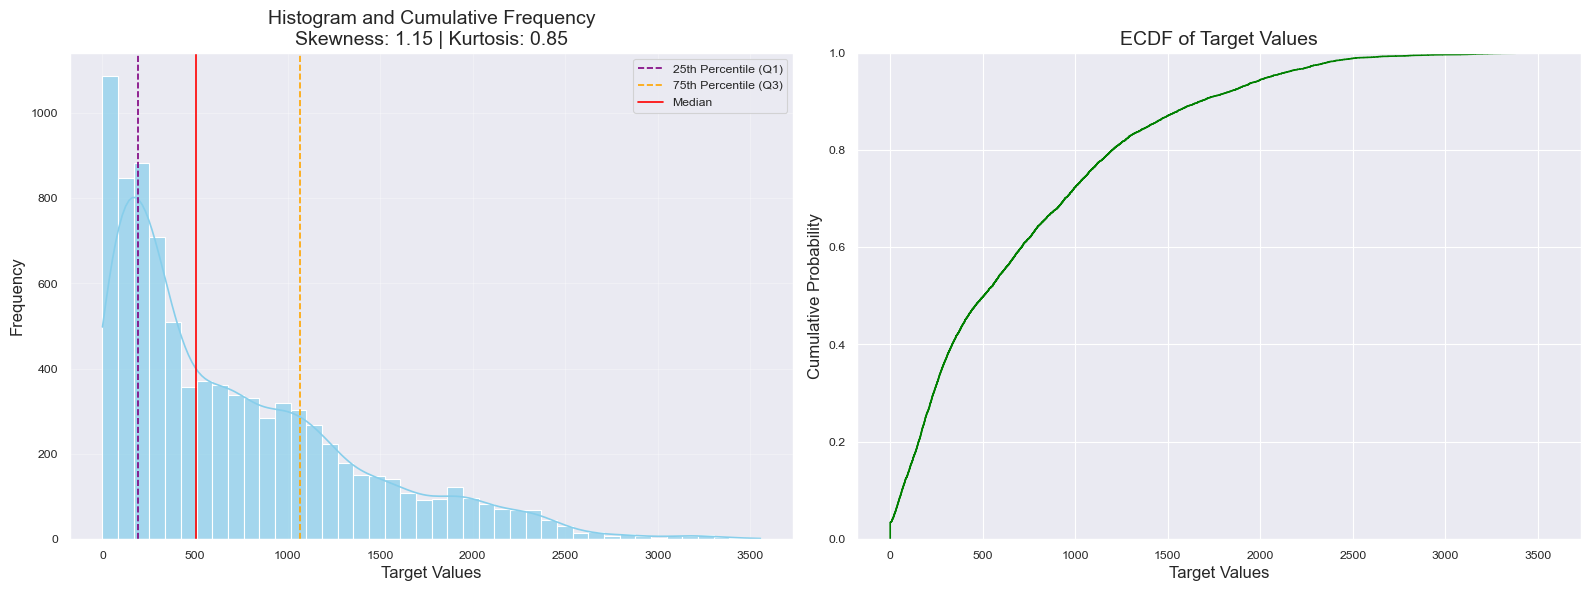

Skewness: 1.15
Kurtosis: 0.85
25th Percentile (Q1): 191.00
75th Percentile (Q3): 1065.25
Interquartile Range (IQR): 874.25


In [171]:
def plot_target_distribution(target, bins=30):
    """
    Plots the distribution of a target variable, calculates its skewness and kurtosis,
    and indicates where most values are concentrated using the IQR. Additionally,
    plots the ECDF of the target variable in a subplot.

    Parameters:
        target (array-like): Target variable data.
        bins (int): Number of bins for the histogram.
    """
    # Calculate skewness and kurtosis
    skewness = skew(target, nan_policy='omit')
    kurt = kurtosis(target, nan_policy='omit', fisher=True)
    
    # Calculate interquartile range (IQR)
    q1 = np.percentile(target, 25)
    q3 = np.percentile(target, 75)
    iqr = q3 - q1
    low = q1
    high = q3

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Histogram and Cumulative Frequency on the first subplot
    sns.histplot(target, kde=True, color="skyblue", alpha=0.7,  ax=axes[0])

    axes[0].set_title(f"Histogram and Cumulative Frequency\nSkewness: {skewness:.2f} | Kurtosis: {kurt:.2f}", fontsize=14)
    axes[0].set_xlabel('Target Values', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    
    # Calculate and plot cumulative frequency
    counts, bin_edges = np.histogram(target, bins=bins)
    
    # Add percentile lines to histogram
    axes[0].axvline(low, color='purple', linestyle='--', label='25th Percentile (Q1)')
    axes[0].axvline(high, color='orange', linestyle='--', label='75th Percentile (Q3)')
    axes[0].axvline(np.median(target), color='red', linestyle='-', label='Median')
    
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # ECDF plot on the second subplot
    sns.ecdfplot(target, ax=axes[1], color='green')
    axes[1].set_title('ECDF of Target Values', fontsize=14)
    axes[1].set_xlabel('Target Values', fontsize=12)
    axes[1].set_ylabel('Cumulative Probability', fontsize=12)

    # Adjust layout for tight spaces
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurt:.2f}")
    print(f"25th Percentile (Q1): {low:.2f}")
    print(f"75th Percentile (Q3): {high:.2f}")
    print(f"Interquartile Range (IQR): {iqr:.2f}")

plot_target_distribution(raw_df[target_col[0]])

It seems like 90% of the time the demand is below 2000, but there at some peak pointsm the demand rises are goes beyond 2000 units per hour. We need to analyze when exaclty this spike occurs to handle the demand accurately. 50% of the time the demand is below 500 units per hour.

##### Independent Features - Discrete Numerical

Analyzing discrete variables

In [172]:
print(f"Discrete Features are: {discrete_cols}")

Discrete Features are: ['hour']


We only have hour feature which is discrete, we can cehck and see if they are consistant.

In [173]:
print(f"Count of Each hours: {raw_df[discrete_cols[0]].value_counts()}.")

Count of Each hours: hour
0     365
1     365
22    365
21    365
20    365
19    365
18    365
17    365
16    365
15    365
14    365
13    365
12    365
11    365
10    365
9     365
8     365
7     365
6     365
5     365
4     365
3     365
2     365
23    365
Name: count, dtype: int64.


We have total of 365 days data, which contributes to one year.

##### Independent Features - Continuos Numerical

In [174]:
print(f"Continous Features are {cont_cols}")

Continous Features are ['humidity', 'snowfall', 'solar_radiation', 'visibility', 'rainfall', 'temperature', 'dew_point_temperature', 'wind_speed']


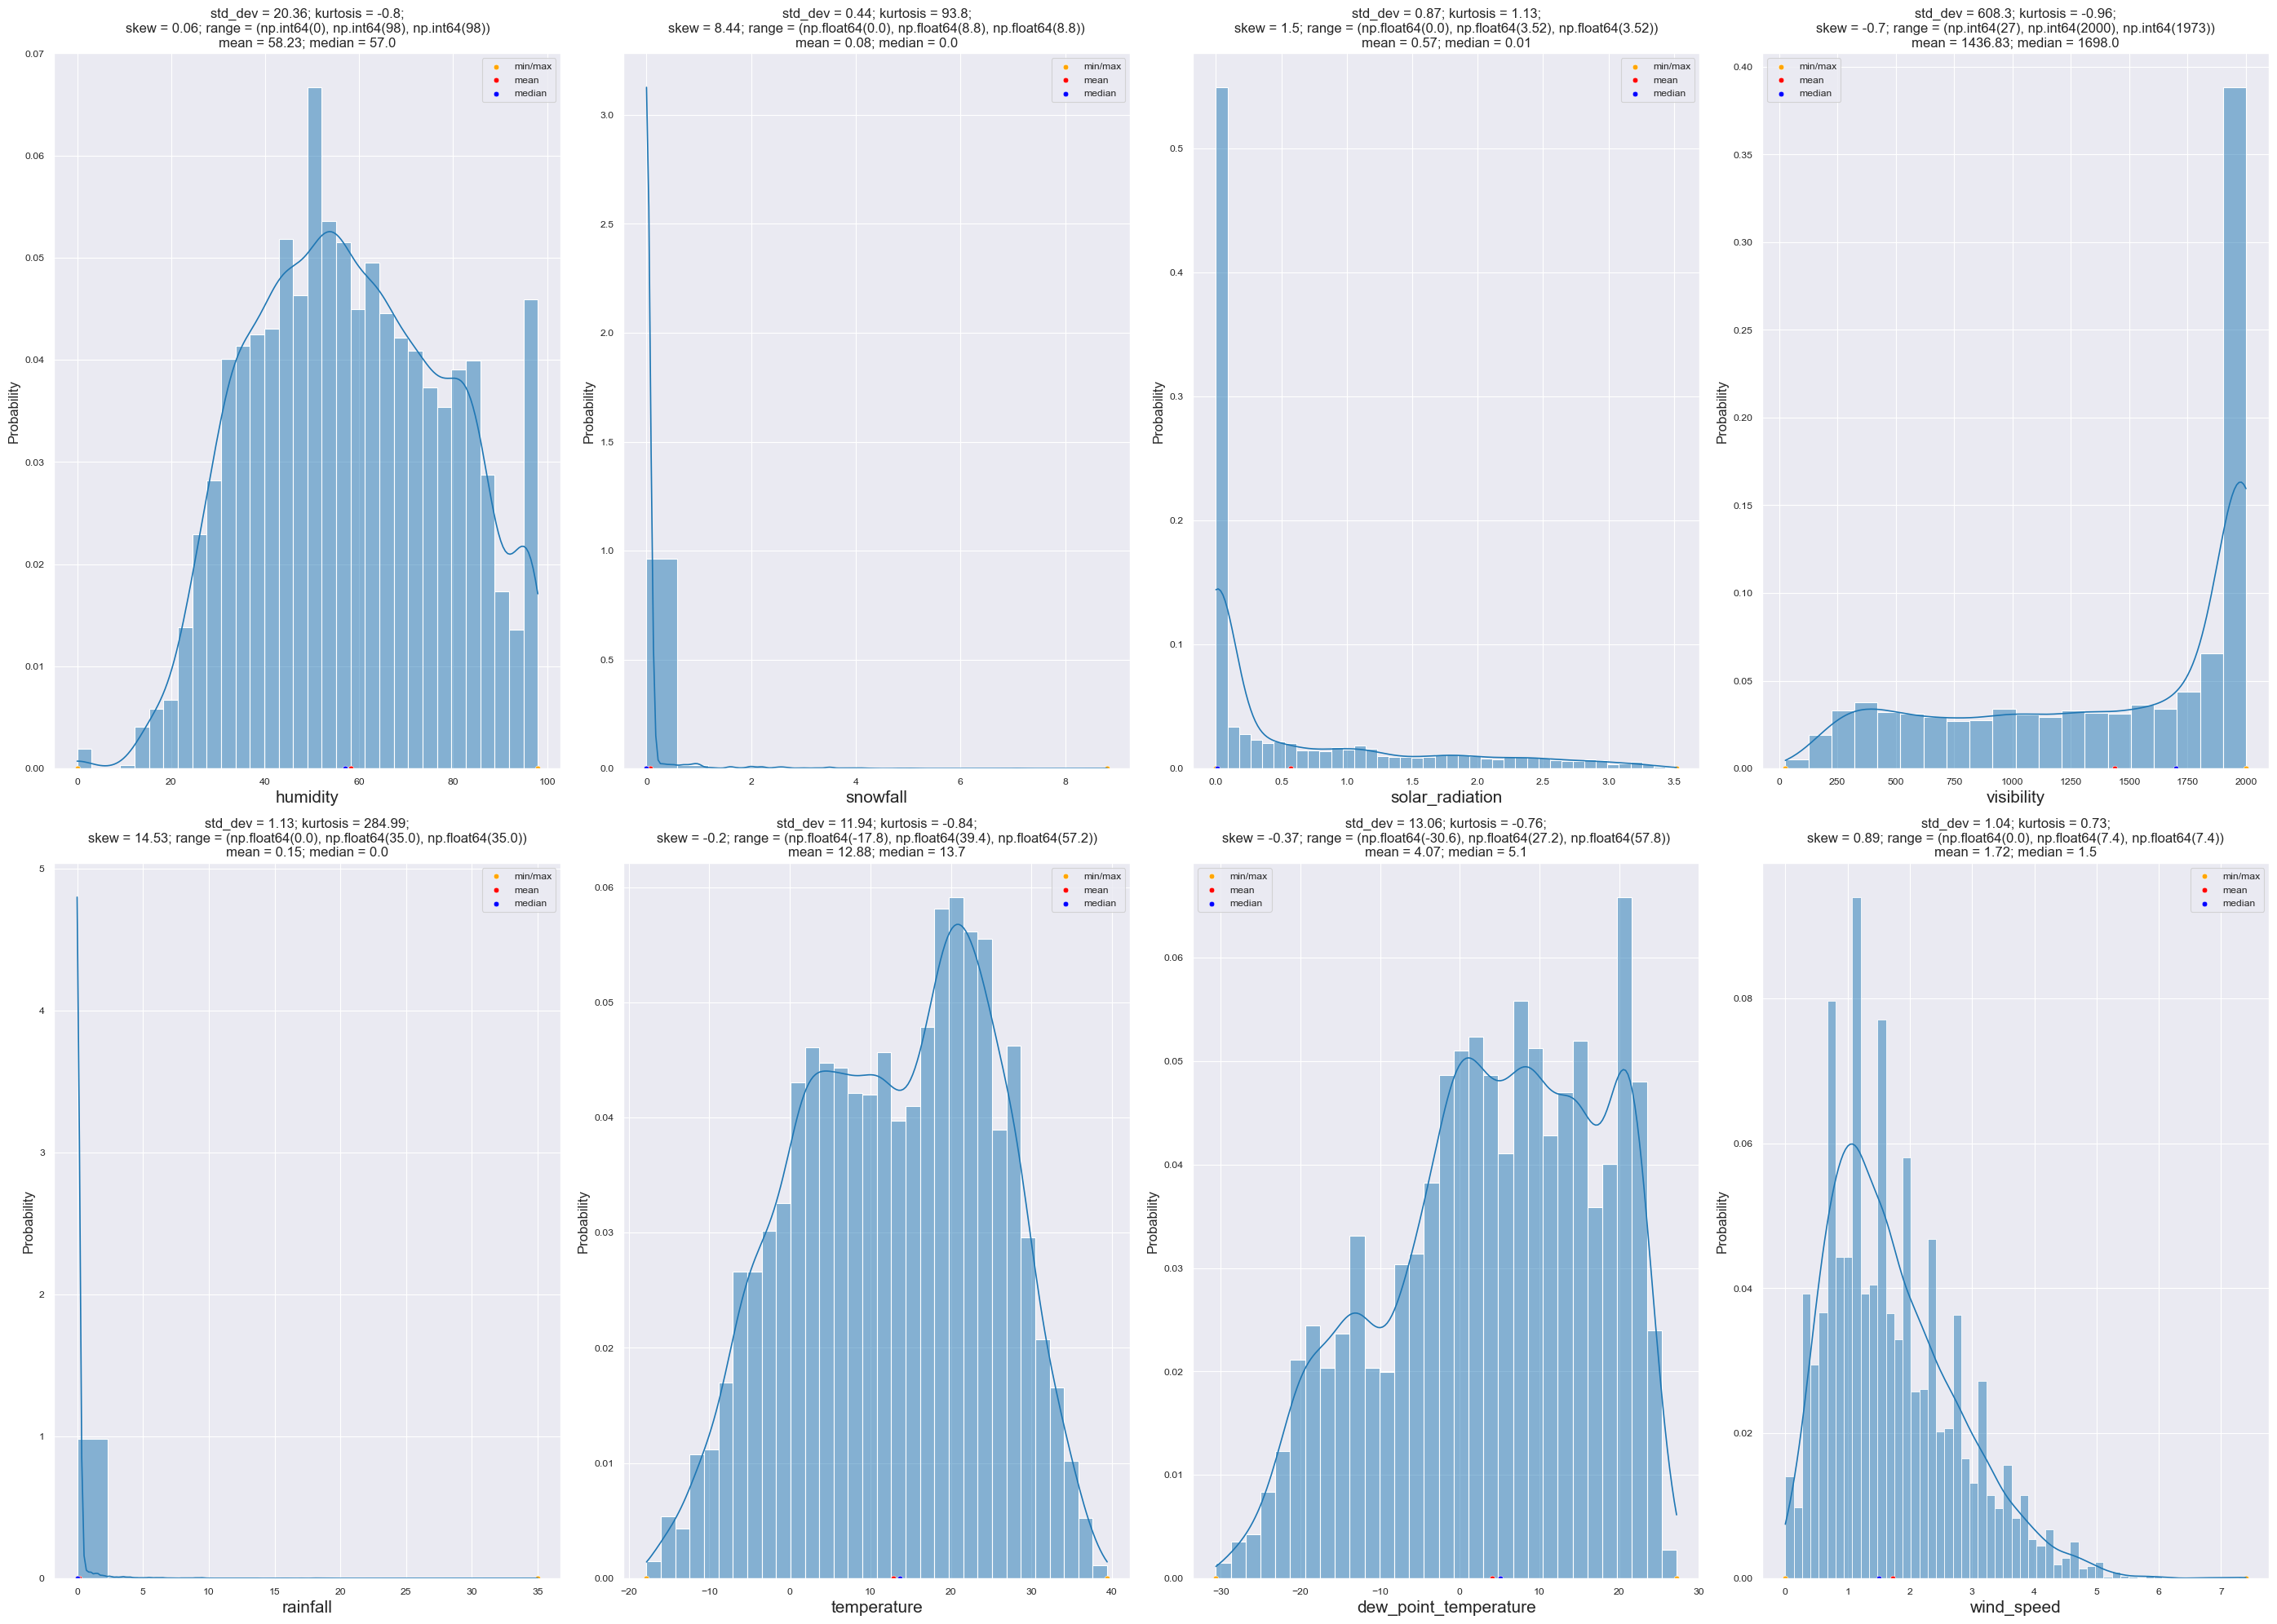

In [ ]:
#Distribution of independant features
def UVA_numeric(data, var_group):
    '''
    Univariate_Analysis_numeric
    takes a group of variables (INTEGER and FLOAT) and plots all the descriptives and properties along with KDE.

    Ensures that there are only four plots per row.
    '''

    size = len(var_group)
    num_cols = 4
    num_rows = (size // num_cols) + (size % num_cols > 0)  # Calculate required rows

    plt.figure(figsize=(7 * num_cols, 10 * num_rows), dpi=100)

    # Looping for each variable
    for j, i in enumerate(var_group):
        # Calculating descriptives of the variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max() - data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # Plotting the variable with every information
        plt.subplot(num_rows, num_cols, j + 1)
        hist_plot = sns.histplot(data[i], stat='probability', kde=True)
        sns.scatterplot(x=[mini, maxi], y=[0, 0], color='orange', label="min/max")
        sns.scatterplot(x=[mean], y=[0], color='red', label="mean")
        sns.scatterplot(x=[median], y=[0], color='blue', label="median")

        plt.xlabel(f'{i}', fontsize=15)
        plt.ylabel('Probability', fontsize=12)
        plt.title(
            'std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format(
                (round(st_dev, 2)),
                round(kurt, 2),
                round(skew, 2),
                (round(mini, 2), round(maxi, 2), round(ran, 2)),
                round(mean, 2),
                round(median, 2)),
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

UVA_numeric(raw_df, cont_cols)

* Snowfall, Solar Radiation, rainfall, visibility has extreme skew and might need disctization technique. 

In [192]:
def discrete_rainfall(df, col='rainfall'):
    # Define conditions for rainfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 2.5),
        (df[col] > 2.5) & (df[col] <= 7.5),
        (df[col] > 7.5) & (df[col] <= 50),
        df[col] > 50
    ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium', 'Heavy', 'Extreme']
    
    # Apply conditions to create the 'rainfall_class' column
    df['rainfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

def discrete_snowfall(df, col='snowfall'):
    # Define conditions for snowfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 0.5),
        (df[col] > 0.5) & (df[col] <= 2.0),
        (df[col] > 2.0) & (df[col] <= 4.0),
        df[col] > 4.0
    ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium', 'Heavy', 'Extreme']
    
    # Apply conditions to create the 'snowfall_class' column
    df['snowfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

def discrete_snowfall(df, col='snowfall'):
    # Define conditions for snowfall categories
    conditions = [
        df[col] == 0,
        (df[col] > 0) & (df[col] <= 0.5),
        (df[col] > 0.5) & (df[col] <= 2.0),
        (df[col] > 2.0) & (df[col] <= 4.0),
        df[col] > 4.0
    ]
    
    # Define corresponding category labels
    categories = ['No', 'Light', 'Medium', 'Heavy', 'Extreme']
    
    # Apply conditions to create the 'snowfall_class' column
    df['snowfall_class'] = np.select(conditions, categories, default='Unknown')
    
    return df

raw_df = discrete_rainfall(raw_df)
raw_df = discrete_snowfall(raw_df)

cat_cols = cat_cols + raw_df.columns[raw_df.columns.str.endswith('_class')].to_list()
print(f"Updated Categorical Columns are: {cat_cols}")

Updated Categorical Columns are: ['seasons', 'holiday', 'functioning_day', 'date', 'rainfall_class', 'snowfall_class']


##### Categorical Feature Analysis